In [102]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization
import time

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("./files/scaled_data.csv", index_col=0)
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')
df

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
Date,,,,,
2009-01-01,0.0,0.175907,0.242507,0.672018,0.260870
2009-01-02,0.0,0.177960,0.163488,0.507291,0.304348
2009-01-03,0.0,0.180698,0.220708,0.624189,0.260870
2009-01-04,0.0,0.182067,0.122616,0.540839,0.260870
2009-01-05,0.0,0.184805,0.049046,0.465917,0.217391
...,...,...,...,...,...
2020-06-26,0.0,0.591376,0.801090,0.462974,0.304348
2020-06-27,0.0,0.588638,0.814714,0.408690,0.260870
2020-06-28,0.0,0.583162,0.833787,0.378186,0.260870


In [103]:
num = 10

In [104]:
def split_data():
    testSize = int(0.3 * len(df))
    train= df.iloc[:-testSize]
    test= df.iloc[-testSize:]
    return train, test
train, test = split_data()

In [105]:
testSize = int(0.3 * len(df))
testSize

1259

In [106]:
def get_order(sr):
    stepwise_fit = auto_arima(sr, suppress_warnings=True, m=365)
    return stepwise_fit
def calc_order():
    order = {}
    for column in df.columns:
        order[column] = {
            'order': get_order(train[column])
        }
    order_df = pd.DataFrame(order)
    return order_df
start = time.time()
order = calc_order()
end = time.time()
print(order)
print(end - start)

MemoryError: Unable to allocate 2.98 GiB for an array with shape (369, 369, 2941) and data type float64

In [ ]:
order

In [ ]:
order.to_csv('order/ARIMA_order_'+str(num)+'.csv', index=False, header=True)

In [15]:
column = 'Temperature'
print(auto_arima(train[column], suppress_warnings=False, trace=True, seasonal=True, m=12))

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-192.467, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-217.220, Time=0.15 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-194.460, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-193.605, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-223.653, Time=0.39 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-223.313, Time=0.36 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-221.875, Time=0.50 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-224.003, Time=0.31 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-217.436, Time=0.12 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=i

In [3]:
import ast
order = pd.read_csv("ARIMA_order_1.csv")

In [72]:
for column in order.columns:
    order[column] = order[column].apply(ast.literal_eval)

ValueError: malformed node or string: (2, 1, 1)

In [23]:
order['Rainfall'][0]

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
def fit_arima(sr):
    model=ARIMA(sr, order=order[sr.name][0].order, seasonal_order=order[sr.name][0].seasonal_order)
    model=model.fit()
    return model

In [ ]:
# Rolling ARIMA algorithm

def arima_roll(column):
    history = train[column].copy()
    predictions = pd.Series(name=column)
    for t in range(len(test)):
        model = fit_arima(history)
        hat = model.forecast()
        predictions = predictions.append(hat)
        history = history.append(pd.Series(test.iloc[t][column], index=[test.index[t]], name=column))
    return predictions

In [ ]:
result_list = []
start = time.time()
for column in df.columns:
    pred = arima_roll(column)
    result_list.append(pred)
    print(pred)
end = time.time()
print(end - start)

In [25]:
pred = arima_roll('River_Hydrometry')

In [26]:
type(pred)

pandas.core.series.Series

In [27]:
result_list.append(pred)

In [ ]:
result_list

In [ ]:
metrics = {}
series = 'River_Hydrometry'
def calc_metrics():

    results = pd.DataFrame(data={'Predictions':pred, 'Actuals':df[series]}, index=pred.index)

    # Step 2: Calculate the differences between the predicted and actual values
    results['Difference'] = results['Actuals'] - results['Predictions']

    # Step 3: Calculate squared differences for RMSE
    results['Squared_difference'] = results['Difference'] ** 2

    # Step 4: Calculate absolute differences for MAE and MAPE
    results['Absolute_difference'] = np.abs(results['Difference'])
    results['Absolute_percentage_difference'] = np.abs(results['Difference'] / results['Actuals'])

    # Step 5: Compute the metrics
    rmse = np.sqrt(results['Squared_difference'].mean())
    mae = results['Absolute_difference'].mean()
    mape = results['Absolute_percentage_difference'].mean() * 100  # to get the percentage
    return rmse, mae, mape

rmse, mae, mape = calc_metrics()
metrics[series] = {
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape
}
metrics_df = pd.DataFrame(metrics)
metrics_df

In [ ]:
combined_dataframe = pd.concat(result_list, axis=1)

In [ ]:
combined_dataframe

In [ ]:
combined_dataframe.to_csv('predictions/ARIMA/'+str(num)+'.csv')
saved_df = combined_dataframe

In [ ]:
metrics = {}
def calc_metrics(name):

    results = pd.DataFrame(data={'Predictions':saved_df[name], 'Actuals':df[name]}, index=saved_df.index)

    # Step 2: Calculate the differences between the predicted and actual values
    results['Difference'] = results['Actuals'] - results['Predictions']

    # Step 3: Calculate squared differences for RMSE
    results['Squared_difference'] = results['Difference'] ** 2

    # Step 4: Calculate absolute differences for MAE and MAPE
    results['Absolute_difference'] = np.abs(results['Difference'])
    results['Absolute_percentage_difference'] = np.abs(results['Difference'] / results['Actuals'])

    # Step 5: Compute the metrics
    rmse = np.sqrt(results['Squared_difference'].mean())
    mae = results['Absolute_difference'].mean()
    mape = results['Absolute_percentage_difference'].mean() * 100  # to get the percentage
    return rmse, mae, mape

for column in df.columns:

    rmse, mae, mape = calc_metrics(column)
    metrics[column] = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv('metrics/ARIMA/'+str(num)+'.csv')

In [ ]:
metrics_df

In [ ]:
import winsound
winsound.Beep(2500,1000)

In [298]:
def arima_roll(df, index, forecast_steps=5):
    train, test = split_data(df)
    history = train.copy()
    predictions_list = []

    for t in range(len(test)):
        model = fit_arima(history, index)

        # Forecast 'forecast_steps' days ahead
        hat = model.forecast(steps=forecast_steps)

        predictions_list.append(hat)
        history = history.copy()
        history = history.append(pd.Series(test[t], index=[test.index[t]]))

    return predictions_list

<Axes: xlabel='Date'>

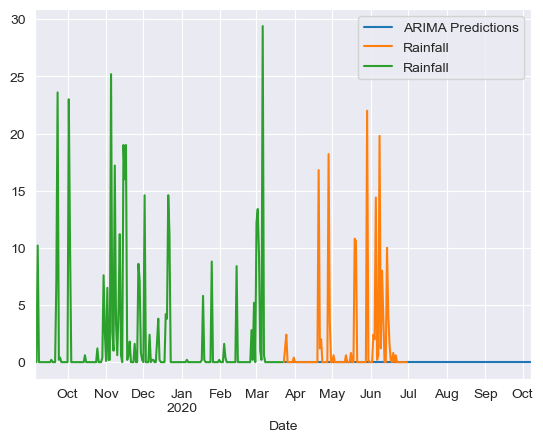

In [19]:
start=len(train[0])
end=len(train[0])+len(test[0])-1
p=models[0].predict(start=start,end=end+100,typ='levels').rename('ARIMA Predictions')
p.plot(legend=True)
test[0].plot(legend=True)
train[0][-200:].plot(legend=True)

In [20]:
type(train)

list

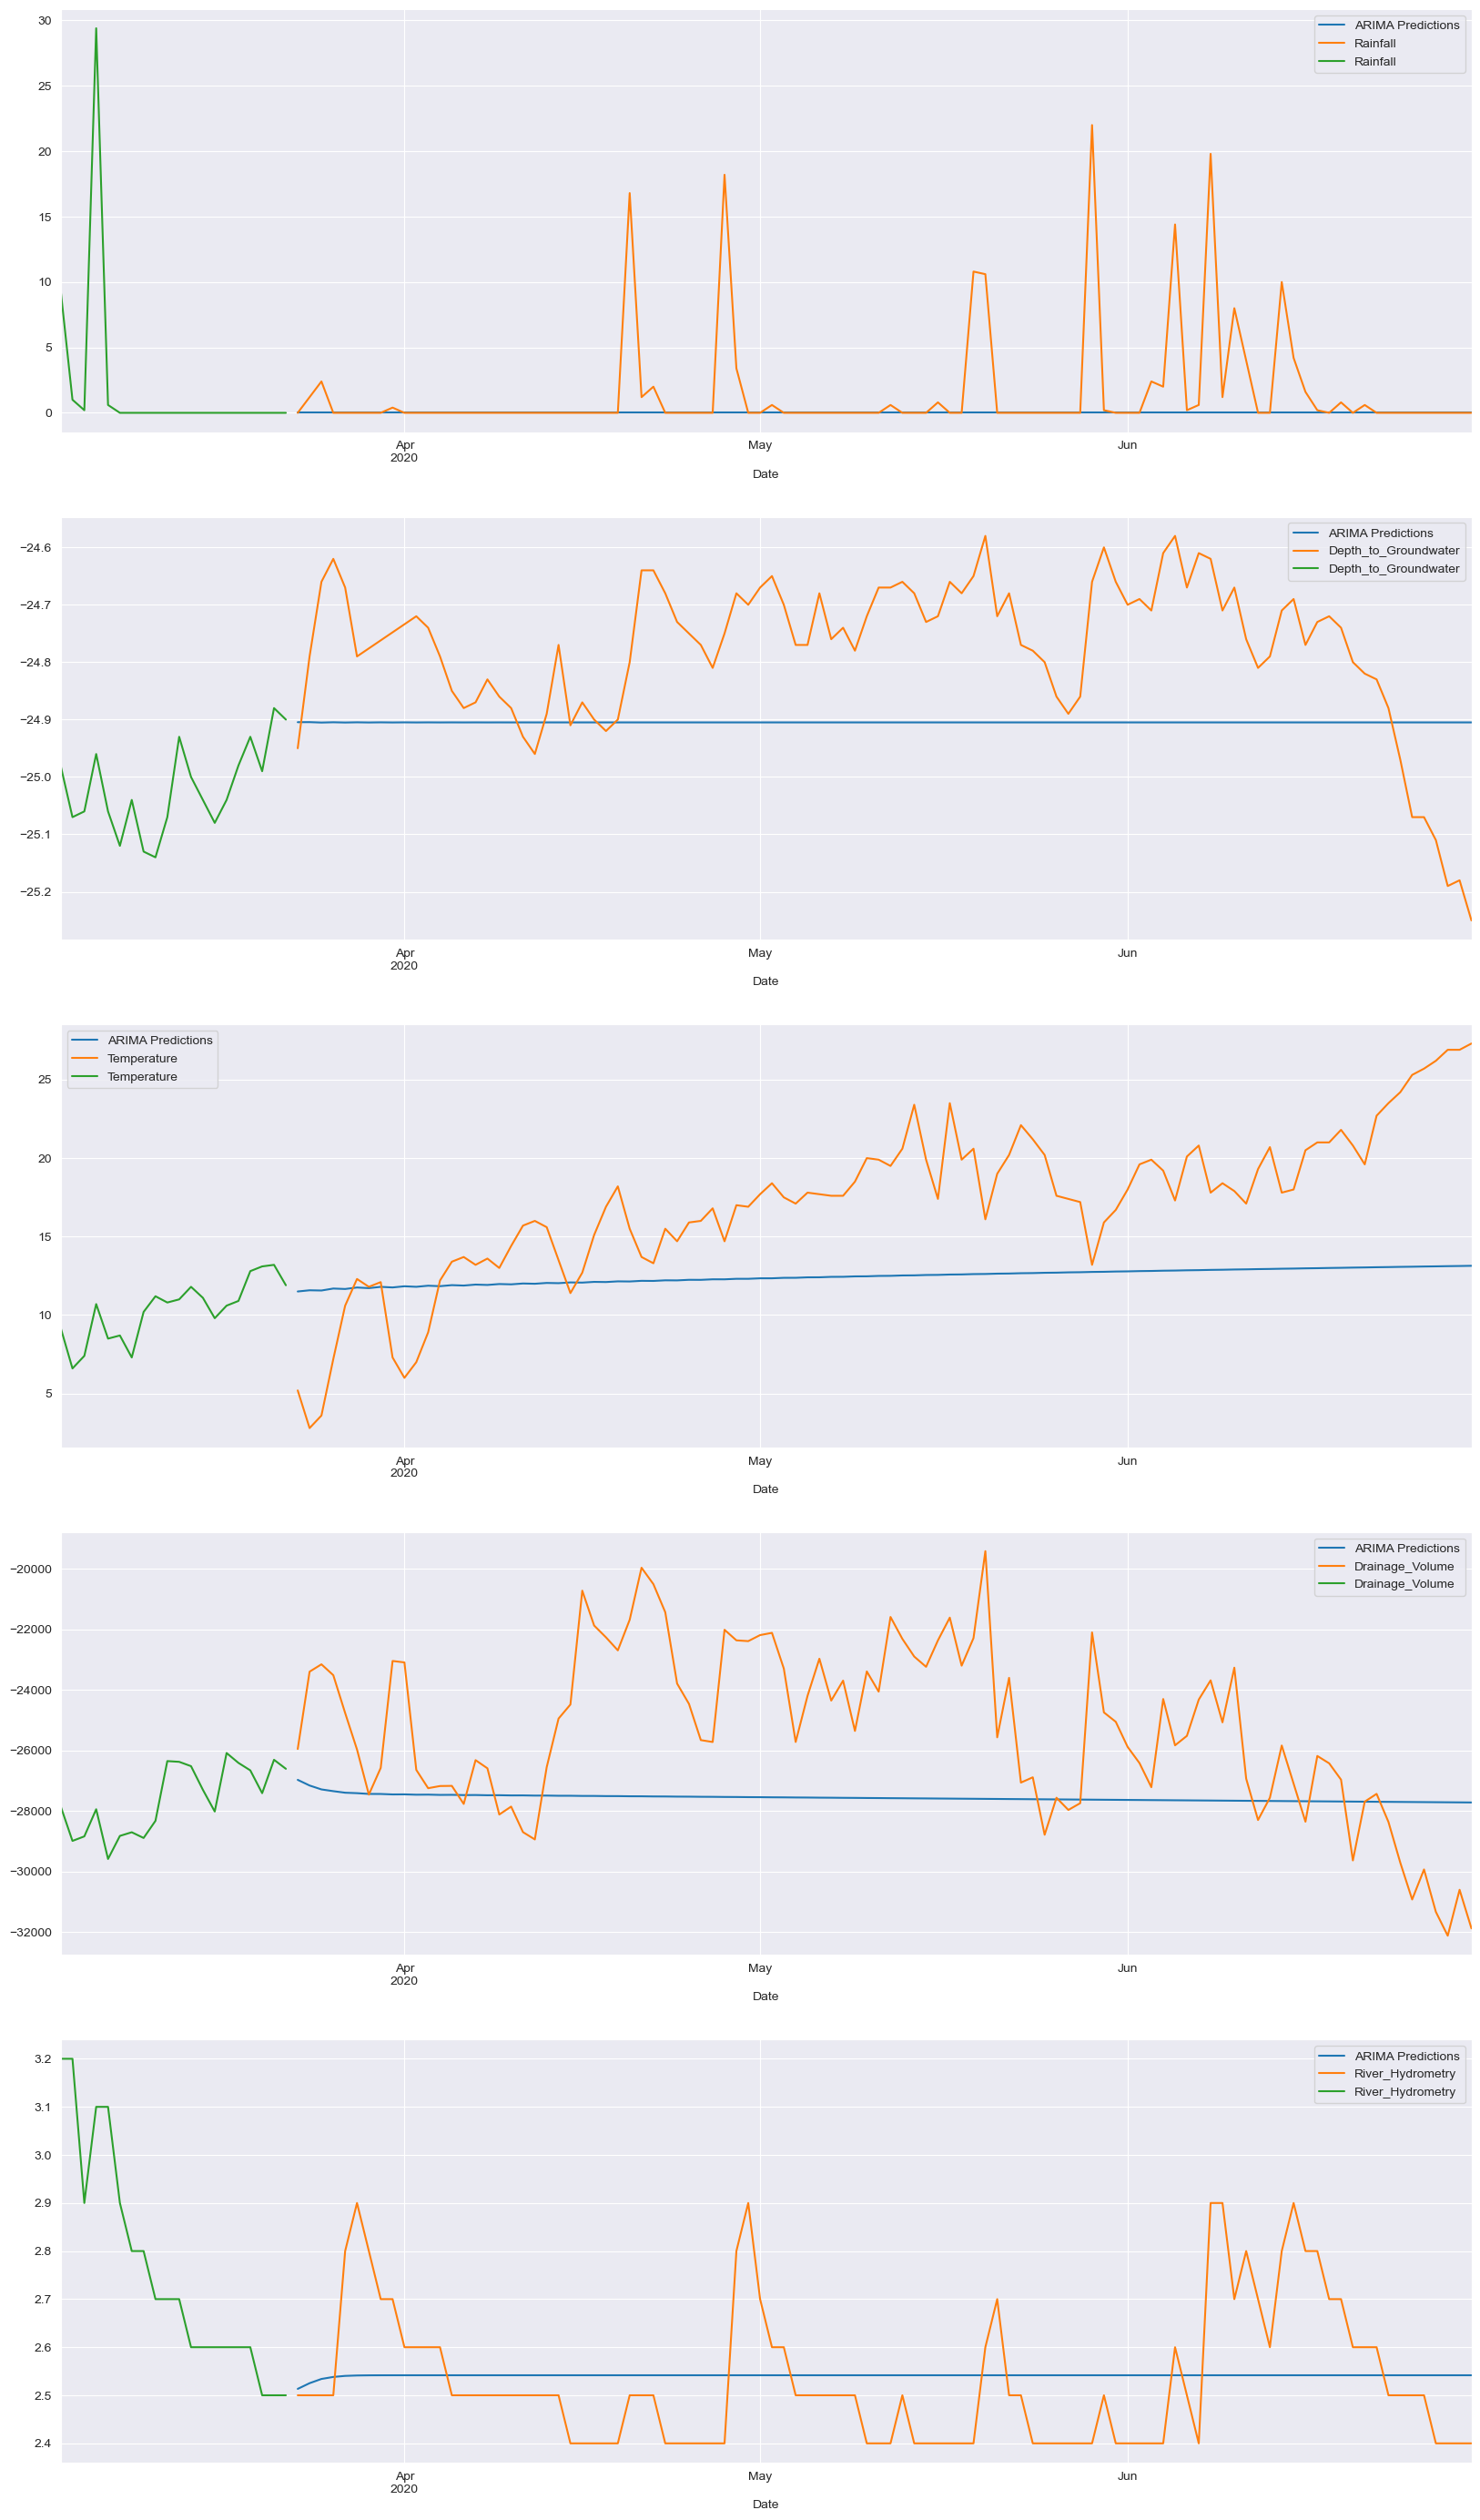

In [271]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(20, 35))
pred = [None] * 5
#forecast_test = [None] * 5
for model in range(0,5):
    start=len(train[model])
    end=len(train[model])+len(test[model])-1
    pred[model]=models[model].predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
    #forecast_test[model] = models[model].forecast(len(test[model]))
    pred[model].plot(ax = ax[model], legend=True)
    test[model].plot(ax = ax[model], legend=True)
    train[model][-20:].plot(ax = ax[model], legend=True)
    #forecast_test[model].plot(ax = ax[model], legend=True)
plt.show()

In [13]:
result_list = []
for index_value in range(5):
    preds_roll = arima_roll(df.iloc[:,index_value], index_value)
    result_list.append(preds_roll)

C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was 

In [15]:
result_list[0]

2020-03-23   -6.767834e-34
2020-03-23   -6.767834e-34
2020-03-23   -6.767834e-34
2020-03-23   -6.767834e-34
2020-03-23   -6.767834e-34
                  ...     
2020-03-23   -6.767834e-34
2020-03-23   -6.767834e-34
2020-03-23   -6.767834e-34
2020-03-23   -6.767834e-34
2020-03-23   -6.767834e-34
Length: 100, dtype: float64

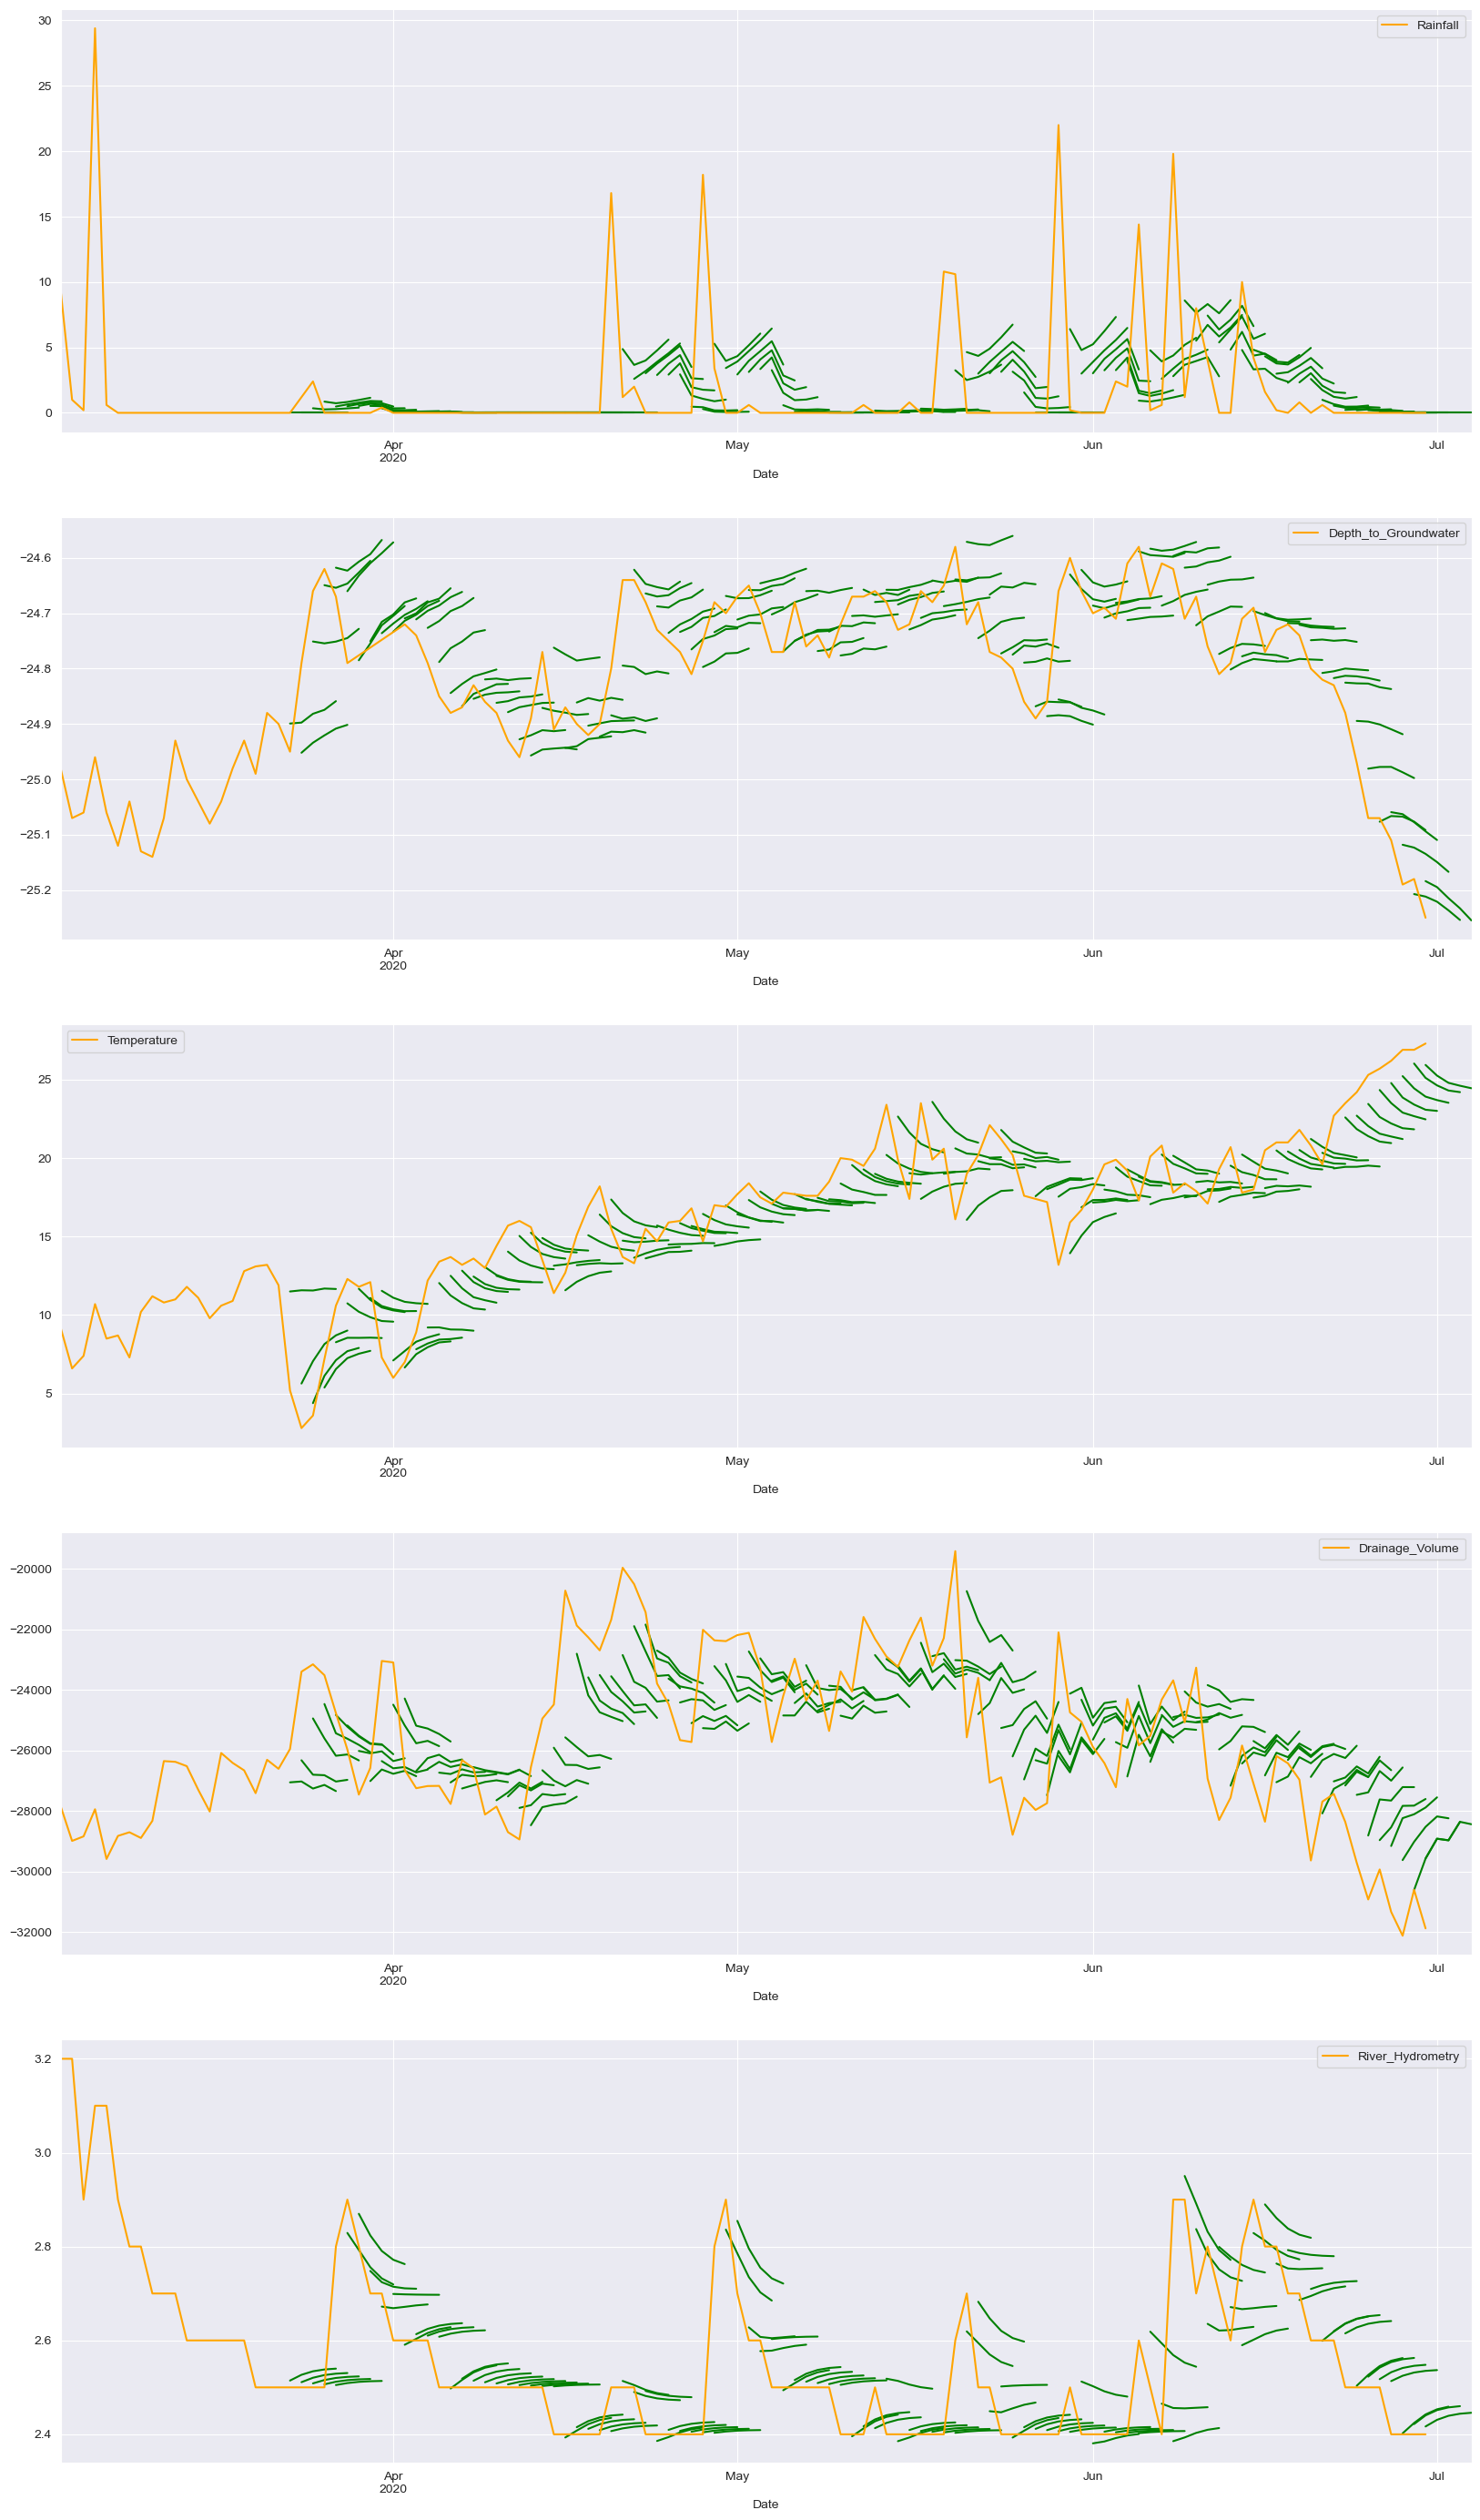

In [312]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(20, 35))
for i in range(5):
    for j in range(len(result_list[i])):
        result_list[i][j].plot(ax = ax[i], label='prediction', color= 'green',legend=False)
    df.iloc[-120:,i].plot(ax = ax[i], color= 'orange', legend=True)
plt.show()

In [160]:
type(result_list)

list

In [125]:
combined_dataframe = pd.concat(result_list, axis=1)

In [126]:
combined_dataframe

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
2017-01-19,0.032611,0.684518,0.229803,0.655559,0.433482
2017-01-20,0.030910,0.683778,0.215109,0.617761,0.481620
2017-01-21,0.030719,0.680399,0.180355,0.564652,0.467181
2017-01-22,0.030737,0.681902,0.186478,0.565926,0.472726
2017-01-23,0.030535,0.688569,0.212995,0.576846,0.471774
...,...,...,...,...,...
2020-06-26,0.023970,0.591034,0.766767,0.457003,0.312190
2020-06-27,0.023789,0.591969,0.771250,0.491621,0.312514
2020-06-28,0.023696,0.587910,0.792587,0.462649,0.263964
2020-06-29,0.023605,0.577687,0.810198,0.431033,0.276683


In [127]:
combined_dataframe.to_csv('predictions/ARIMA/4.csv')

In [147]:
saved_df = pd.read_csv('./predictions/ARIMA/4.csv', index_col=0)
saved_df.index = pd.to_datetime(saved_df.index, format = '%Y-%m-%d')

In [38]:
saved_df = combined_dataframe

<Axes: xlabel='Date'>

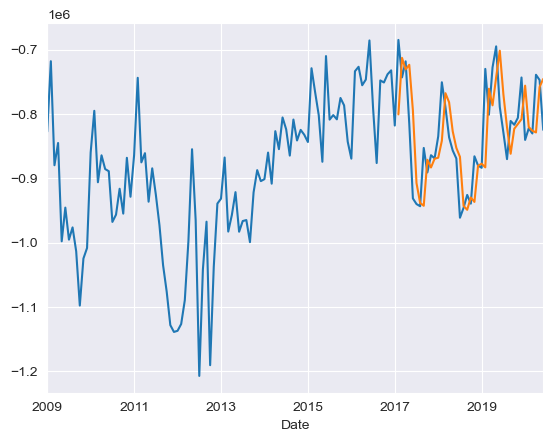

In [86]:
df['Drainage_Volume'].plot()
saved_df['Drainage_Volume'].plot()

In [52]:
saved_df['Drainage_Volume'].loc['2020-02-07']

-27915.15798697891

In [53]:
saved_df['Drainage_Volume'].loc['2020-02-06'] = -27915.15798697891

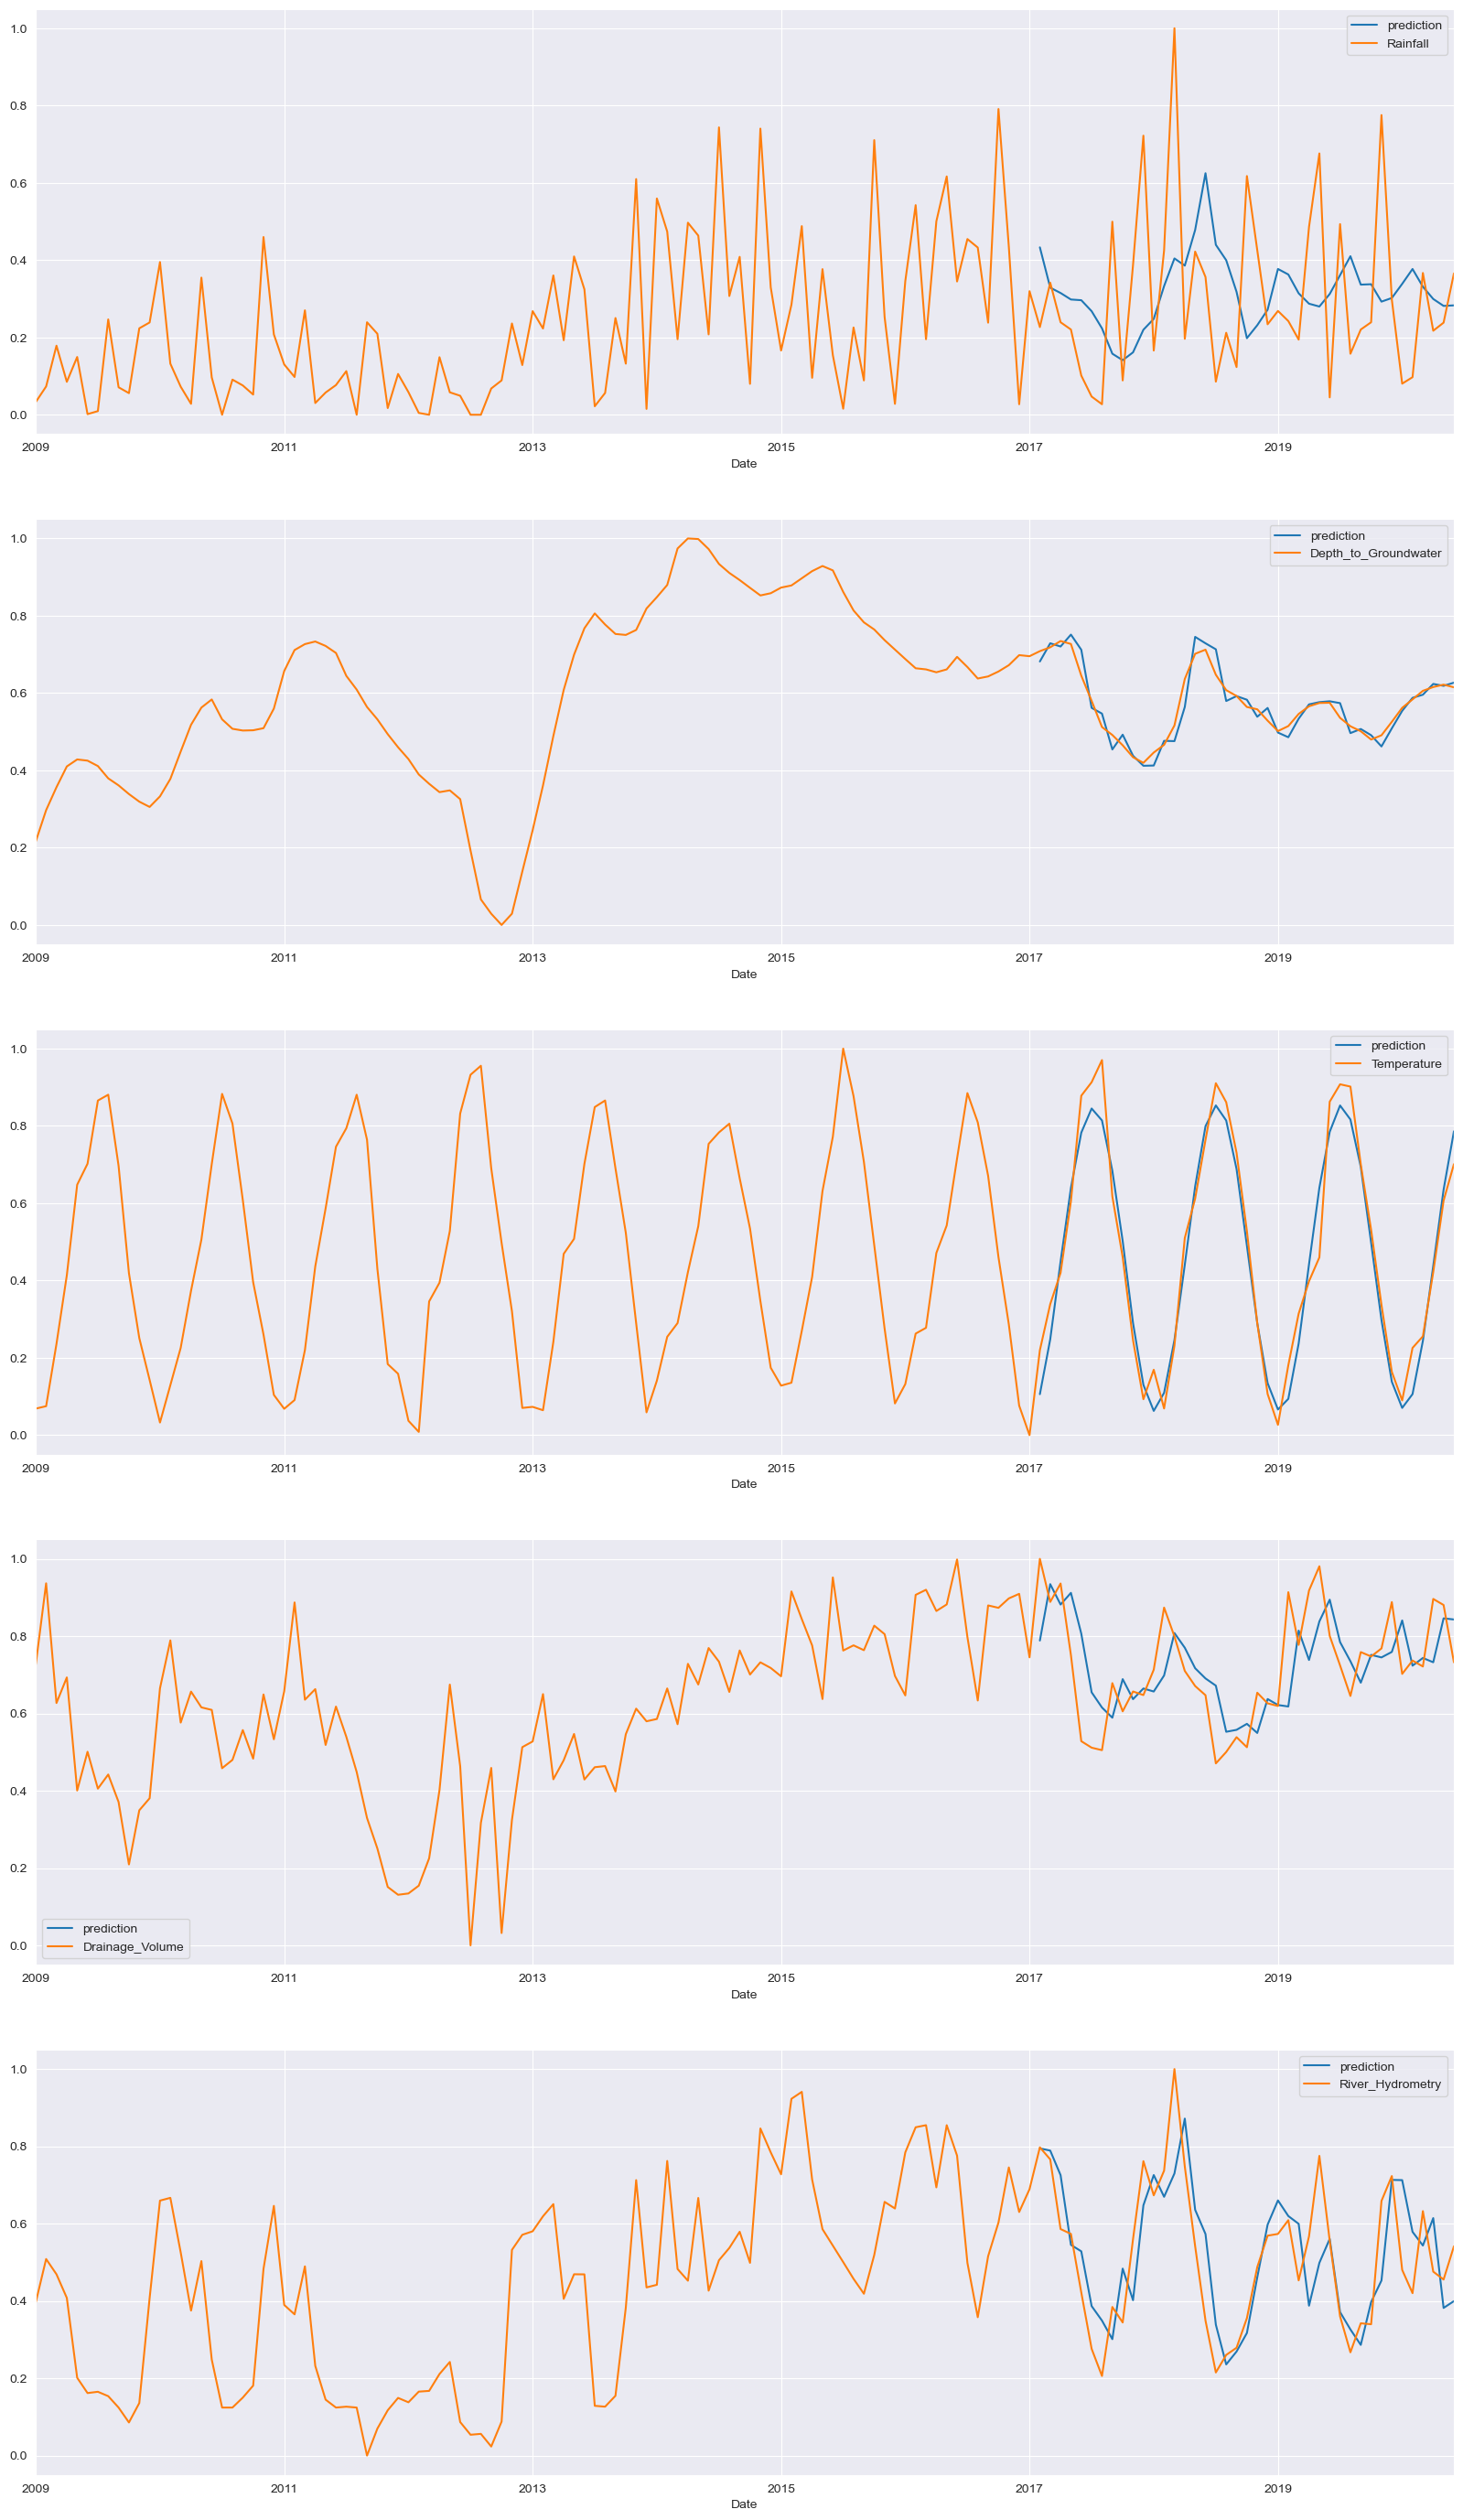

In [171]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(20, 35))
for i in range(5):
    saved_df.iloc[-200:,i].plot(ax = ax[i], label='prediction', legend=True)
    df.iloc[-200:,i].plot(ax = ax[i], legend=True)
plt.show()

In [40]:
metrics_df

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
RMSE,0.237102,0.025640,0.065865,0.099227,0.110857
MAE,0.191650,0.019481,0.051711,0.076363,0.091448
MAPE,116.932364,3.407715,24.546430,10.803707,20.244332


In [85]:
name = 'Rainfall'
results = pd.DataFrame(data={'Predictions':saved_df[name], 'Actuals':df[name]}, index=saved_df.index)
results

,Predictions,Actuals
2017-02-28,82.889216,43.4
2017-03-31,62.933506,65.4
2017-04-30,60.288811,45.8
2017-05-31,57.066871,42.2
2017-06-30,56.716981,19.4
2017-07-31,51.280448,9.0
2017-08-31,42.778151,5.2
2017-09-30,30.223656,95.6
2017-10-31,27.011079,17.0
2017-11-30,30.897622,74.2


In [82]:
metrics_df

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
RMSE,4.665199,0.062160,1.894781,1703.653534,0.098455
MAE,2.351457,0.048669,1.464639,1363.408908,0.058701
MAPE,inf,0.196434,10.967746,5.493735,2.243815


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

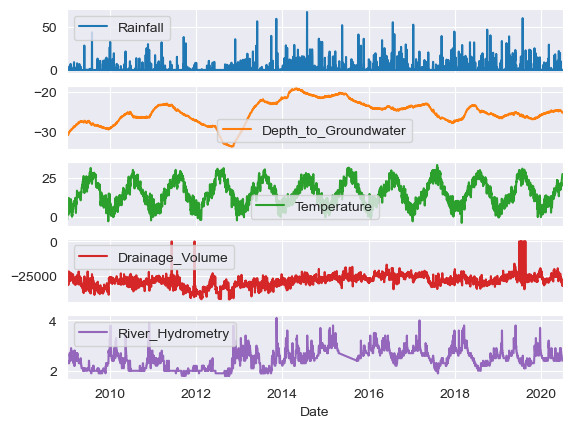

In [54]:
df.plot(subplots=True)

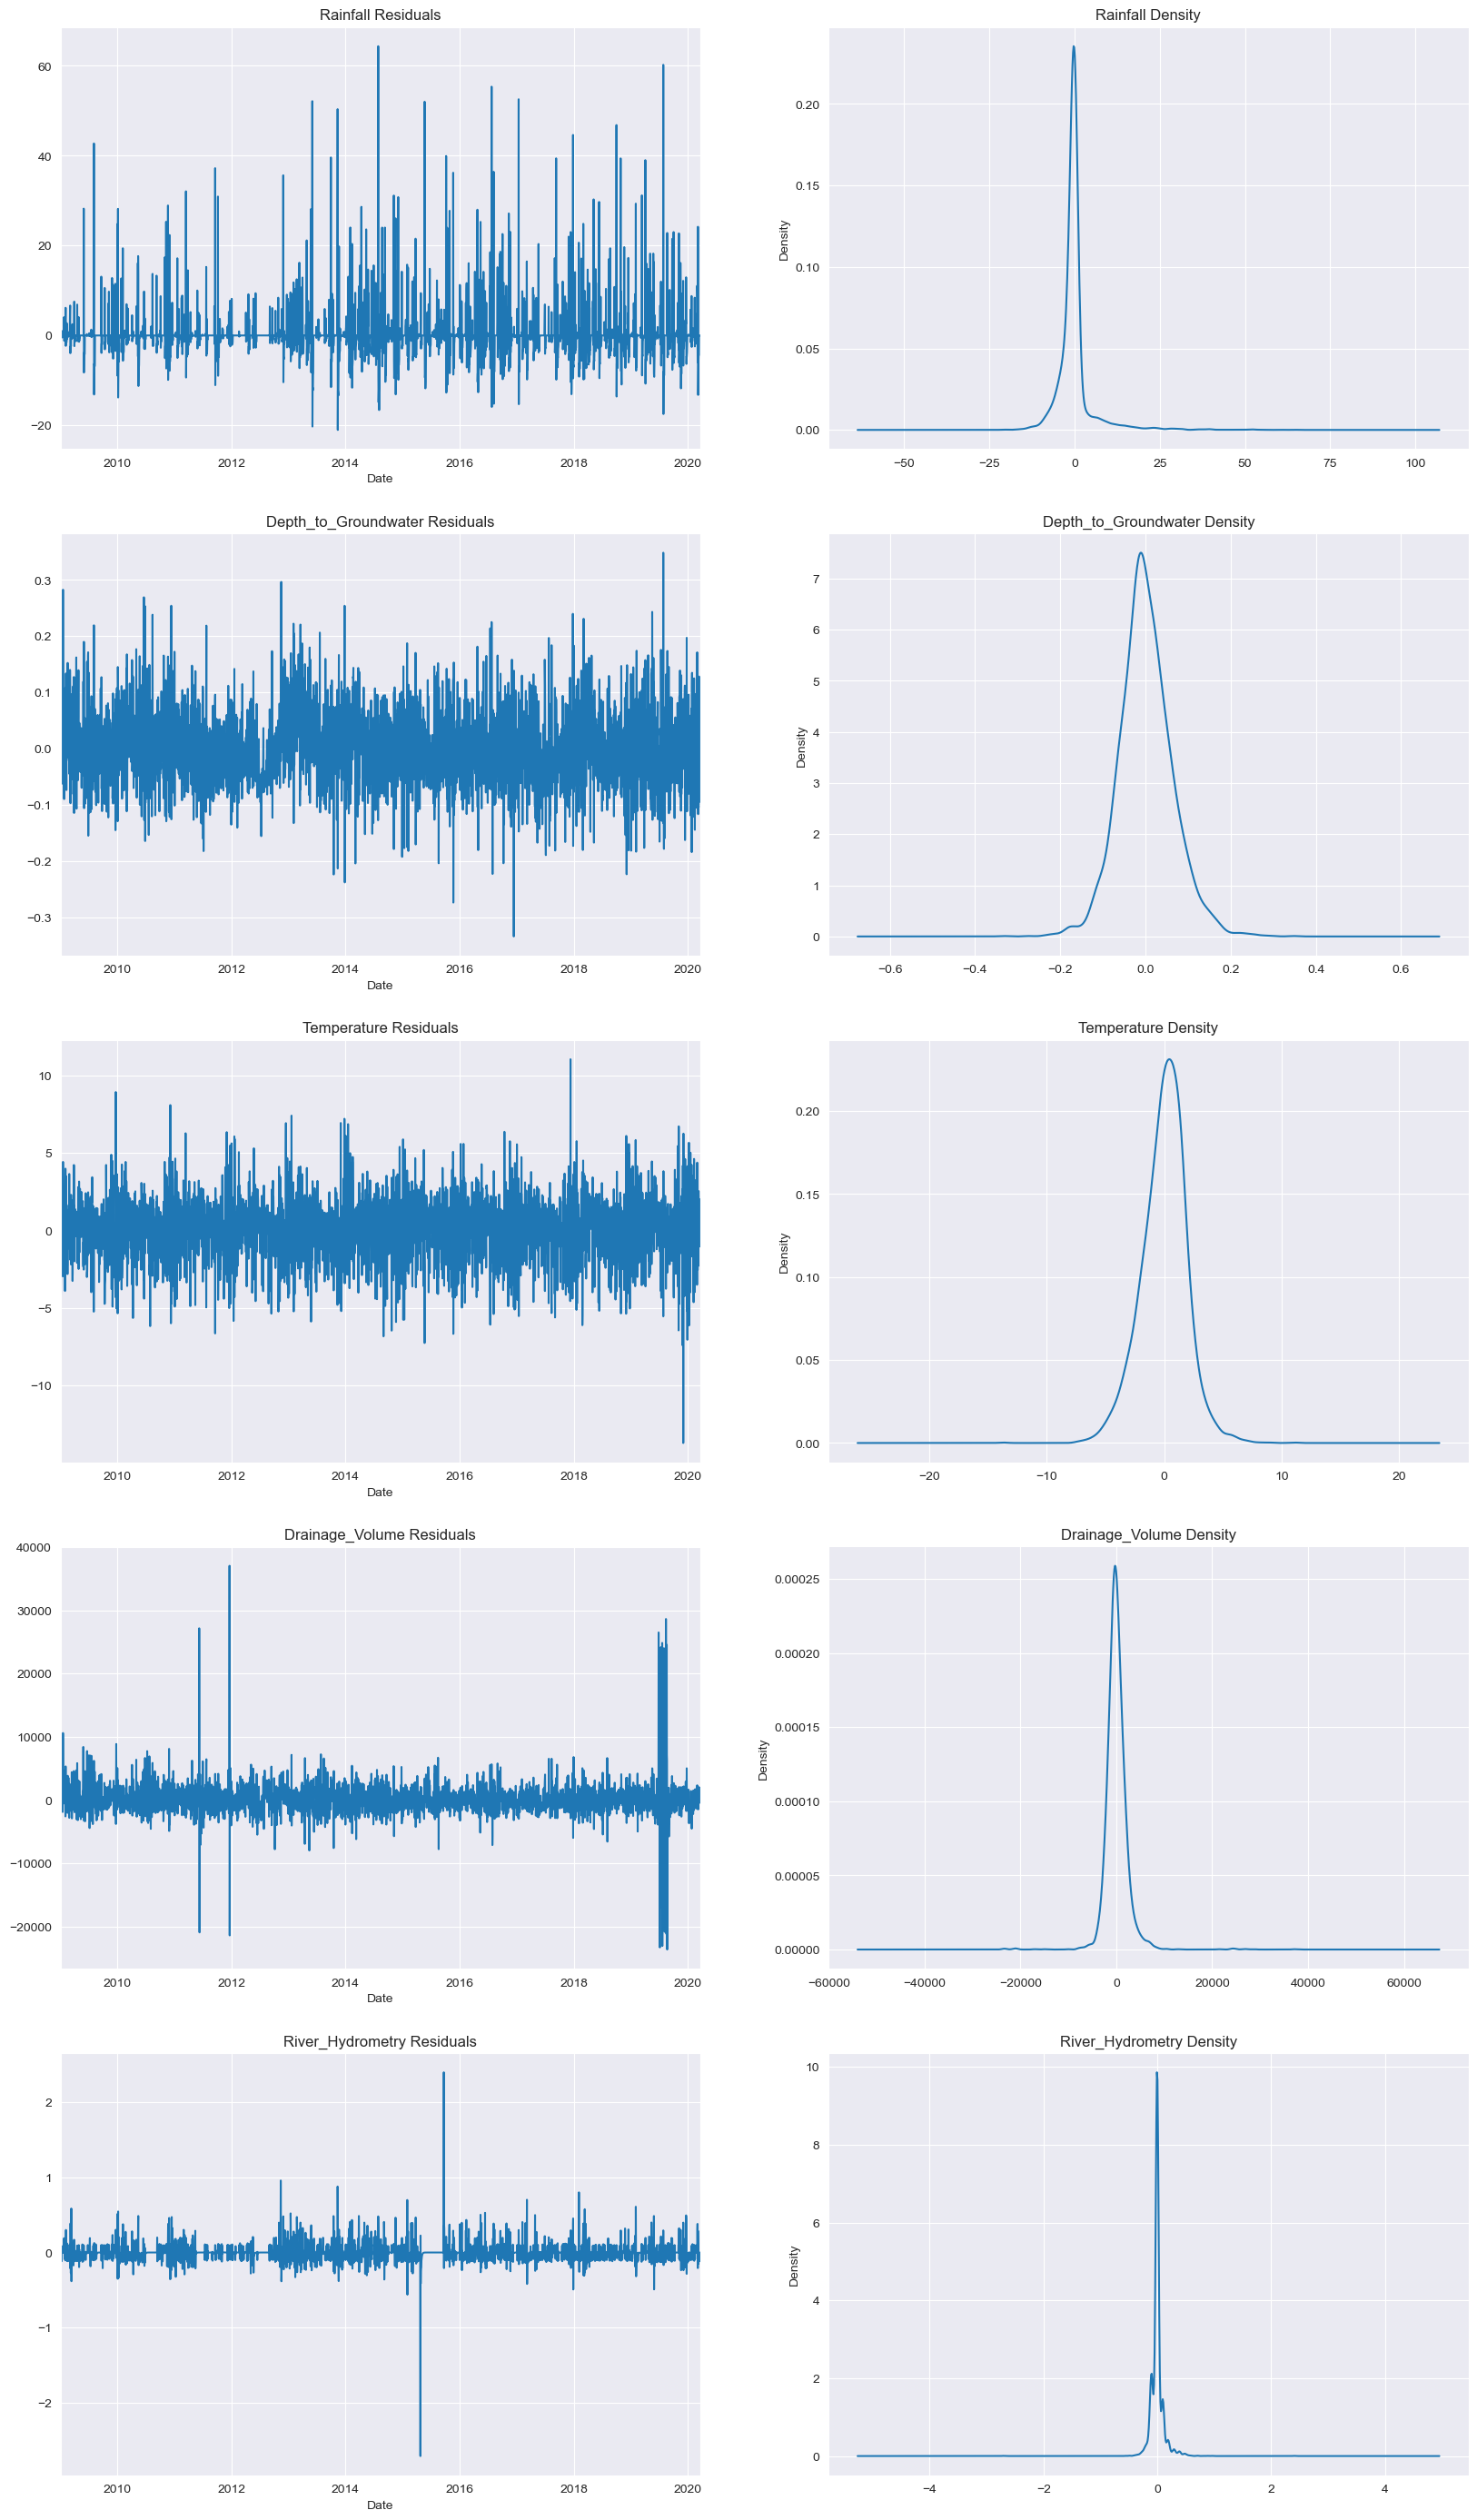

In [18]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 35))
for model in range(0,5):
    residuals =models[model].resid[1:]
    residuals.plot(title= train[model].name + ' Residuals', ax=ax[model,0])
    residuals.plot(title=train[model].name + ' Density', kind='kde', ax=ax[model,1])
plt.show()

In [5]:
import statsmodels.api as sm
print(sm.tsa.stattools.grangercausalitytests(df[['Depth_to_Groundwater','Temperature']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=195.2958, p=0.0000  , df_denom=4195, df_num=1
ssr based chi2 test:   chi2=195.4355, p=0.0000  , df=1
likelihood ratio test: chi2=191.0227, p=0.0000  , df=1
parameter F test:         F=195.2958, p=0.0000  , df_denom=4195, df_num=1
{1: ({'ssr_ftest': (195.2958042708085, 2.0598781696654857e-43, 4195.0, 1), 'ssr_chi2test': (195.43546753965535, 2.0700048122999817e-44, 1), 'lrtest': (191.02271184662823, 1.901508244143133e-43, 1), 'params_ftest': (195.29580427084892, 2.059878169626114e-43, 4195.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000022A821DC910>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000022A82379F70>, array([[0., 1., 0.]])])}
